# Dataset


In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.24.4 --force-reinstall

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 48.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.


In [ ]:
!wget https://download.microsoft.com/download/a/d/f/adfce572-617f-4fd0-a822-af6f05cbe61f/MicrosoftGestureDataset.zip
!unzip MicrosoftGestureDataset.zip -d MSRC_12

--2025-04-20 13:38:37--  https://download.microsoft.com/download/a/d/f/adfce572-617f-4fd0-a822-af6f05cbe61f/MicrosoftGestureDataset.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.84.168.159, 2600:1407:b800:28b::317f, 2600:1407:b800:290::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.84.168.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173190554 (165M) [application/octet-stream]
Saving to: ‘MicrosoftGestureDataset.zip’

MicrosoftGestureDat 100%[===================>] 165.17M   218MB/s    in 0.8s    

2025-04-20 13:38:38 (218 MB/s) - ‘MicrosoftGestureDataset.zip’ saved [173190554/173190554]

Archive:  MicrosoftGestureDataset.zip
   creating: MSRC_12/MicrosoftGestureDataset-RC/code/
  inflating: MSRC_12/MicrosoftGestureDataset-RC/code/demo1.m  
  inflating: MSRC_12/MicrosoftGestureDataset-RC/code/load_file.m  
  inflating: MSRC_12/MicrosoftGestureDataset-RC/code/load_tagstream.m  
  inflating: MSRC_12/MicrosoftGe

In [ ]:
!pip install grakel==0.1.10
import numpy as np
import grakel
import os
import csv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.6 MB/s eta 0:00:00


In [ ]:
# Liste officielle des gestes
TAGSET = [
    "G1  lift outstretched arms", "G2  Duck", "G3  Push right",
    "G4  Goggles", "G5  Wind it up", "G6  Shoot",
    "G7  Bow", "G8  Throw", "G9  Had enough",
    "G10 Change weapon", "G11 Beat both", "G12 Kick"
]

def load_tagstream(tagstream_file, allowed_tags=None):
    tags = []
    with open(tagstream_file, 'r') as f:
        reader = csv.reader(f, delimiter=';')
        next(reader)  # skip header
        for row in reader:
            if len(row) != 2:
                continue
            tick_str, tagname = row
            try:
                xqpctick = int(tick_str)
            except ValueError:
                continue
            timestamp_usec = int((xqpctick * 1000 + 49875 / 2) / 49875)
            if allowed_tags is None or tagname in allowed_tags:
                tags.append({'timestamp_usec': timestamp_usec, 'tagname': tagname})
    return tags

def load_file(file_basename, base_path="MSRC_12/MicrosoftGestureDataset-RC/data", discard_zero_frames=True):
    csv_path = os.path.join(base_path, f"{file_basename}.csv")
    tag_path = os.path.join(base_path, f"{file_basename}.tagstream")

    # Lecture des données CSV
    X_raw = np.loadtxt(csv_path)
    timestamps = X_raw[:, 0].astype(int)
    X = X_raw[:, 1:]

    if discard_zero_frames:
        magnitudes = np.sum(np.abs(X), axis=1)
        nonzero_start = np.argmax(magnitudes > 1e-10)
        X = X[nonzero_start:]
        timestamps = timestamps[nonzero_start:]

    tags = load_tagstream(tag_path, TAGSET)

    return X, timestamps, tags

def create_skeleton_edges():
    return [
        (0, 1), (1, 2), (2, 3),
        (2, 4), (4, 5), (5, 6), (6, 7),
        (2, 8), (8, 9), (9,10), (10,11),
        (0,12), (12,13), (13,14), (14,15),
        (0,16), (16,17), (17,18), (18,19),
    ]

import numpy as np

def convert_sequence_to_grakel_graphs(X, timestamps, tags, fps=30):
    relative_position_indices = [
        0,  # HIP_CENTER -> self
        0,  # SPINE -> HIP_CENTER
        1,  # SHOULDER_CENTER -> SPINE
        2,  # HEAD -> SHOULDER_CENTER
        2,  # SHOULDER_LEFT -> SHOULDER_CENTER
        4,  # ELBOW_LEFT -> SHOULDER_LEFT
        5,  # WRIST_LEFT -> ELBOW_LEFT
        6,  # HAND_LEFT -> WRIST_LEFT
        2,  # SHOULDER_RIGHT -> SHOULDER_CENTER
        8,  # ELBOW_RIGHT -> SHOULDER_RIGHT
        9,  # WRIST_RIGHT -> ELBOW_RIGHT
        10, # HAND_RIGHT -> WRIST_RIGHT
        0,  # HIP_LEFT -> HIP_CENTER
        12, # KNEE_LEFT -> HIP_LEFT
        13, # ANKLE_LEFT -> KNEE_LEFT
        14, # FOOT_LEFT -> ANKLE_LEFT
        0,  # HIP_RIGHT -> HIP_CENTER
        16, # KNEE_RIGHT -> HIP_RIGHT
        17, # ANKLE_RIGHT -> KNEE_RIGHT
        18  # FOOT_RIGHT -> ANKLE_RIGHT
    ]

    sequences = []

    for tag in tags:
        tag_time = tag["timestamp_usec"]

        # Find the closest frame index to the tag timestamp
        closest_idx = min(
            range(len(timestamps)),
            key=lambda i: abs(int((timestamps[i] * 1000 + 49875 / 2) / 49875) - tag_time)
        )

        if closest_idx >= fps:
            sequence_array = np.zeros((fps, 20, 6))  # (30, 20, 6)

            previous_relative = None

            for i in range(fps):
                frame = X[closest_idx - fps + i].reshape(20, 4)[:, :3]
                relative = frame - frame[relative_position_indices]

                if previous_relative is None:
                    speed = np.zeros_like(relative)
                else:
                    speed = relative - previous_relative

                sequence_array[i, :, :3] = relative
                sequence_array[i, :, 3:] = speed

                previous_relative = relative

            sequences.append(sequence_array)
            tags_list.append(tag['tagname'])

    return np.array(sequences)  # shape: (num_sequences, 30, 20, 6)


# Loop through all files in the directory and create graphs for each
msrc_12_graphs = []
timestamps_list = []
tags_list = []

data_dir = "MSRC_12/MicrosoftGestureDataset-RC/data"
for file_name in os.listdir(data_dir):
  if not ("P2_1_2A_p12" in file_name):
    if file_name.endswith(".csv"):
        # Extract the file basename without extension
        base_name = file_name.split(".")[0]

        # Load the data for this file
        X, timestamps, tags = load_file(base_name)

        # Convert the sequence to Grakel graphs
        grakel_graphs = convert_sequence_to_grakel_graphs(X,timestamps, tags)

        # Append the graphs for this file to the MSRC_12 variable
        msrc_12_graphs.extend(grakel_graphs)
        timestamps_list.extend(timestamps)

# Now msrc_12_graphs contains the graphs for all the files in the dataset
print(f"Total number of graphs: {len(msrc_12_graphs)}")


Total number of graphs: 6247


In [ ]:
HIP_CENTER = 0
SPINE = 1
SHOULDER_CENTER = 2
HEAD = 3
SHOULDER_LEFT = 4
ELBOW_LEFT = 5
WRIST_LEFT = 6
HAND_LEFT = 7
SHOULDER_RIGHT = 8
ELBOW_RIGHT = 9
WRIST_RIGHT = 10
HAND_RIGHT = 11
HIP_LEFT = 12
KNEE_LEFT = 13
ANKLE_LEFT = 14
FOOT_LEFT = 15
HIP_RIGHT = 16
KNEE_RIGHT = 17
ANKLE_RIGHT = 18
FOOT_RIGHT = 19

# Propagation Kernel

In [ ]:
from grakel import Graph
from grakel.kernels import PropagationAttr
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

def summarize_segment(segment):
    pos = segment[:, :, :3]  # shape: (frames, joints, 3)
    vel = segment[:, :, 3:]  # shape: (frames, joints, 3)
    pos_mean = np.mean(pos, axis=0)
    vel_mean = np.mean(vel, axis=0)
    return np.concatenate([pos_mean, vel_mean], axis=1)  # shape: (20, 6)

def build_temporal_histogram_graph(sequence,n = 4):
    segment_len = len(sequence) // n
    features = []
    for i in range(n):
        segment = sequence[i*segment_len:(i+1)*segment_len]
        summary = summarize_segment(np.array(segment))  # (20, 6)
        features.append(summary)
    final_features = np.concatenate(features, axis=1)  # (20, n*6)
    return final_features

In [ ]:
edges = create_skeleton_edges()

ws = []
accs = []
confs = []
fracs = []

for frac in [4, 8, 16]:
  grakel_graphs = []
  labels = []
  for sequence, label in zip(msrc_12_graphs, tags_list):
      final_features = build_temporal_histogram_graph(sequence, n=frac)

      # Convert node features to lists (GraKeL can't handle NumPy arrays directly)
      final_features = {i: final_features[i].tolist() for i in range(final_features.shape[0])}

      # Create the graph: (edges, node_features)
      g = Graph(edges, node_labels=final_features, edge_labels=None, graph_format="all")

      grakel_graphs.append(g)
      labels.append(label)

  # Split into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(grakel_graphs, labels, test_size=0.2, random_state=42, stratify=labels)

  for w in [1, 2, 4, 8]:
    for t in [1, 2, 4, 8]:
      # Define the propagation kernel
      kernel = PropagationAttr(normalize=False, t_max=t, w=w)

      # Compute the kernel matrices
      K_train = kernel.fit_transform(X_train)
      K_test = kernel.transform(X_test)

      # Train SVM classifier
      clf = SVC(kernel='precomputed')
      clf.fit(K_train, y_train)

      # Predict and evaluate
      y_pred = clf.predict(K_test)
      conf_mat = confusion_matrix(y_test, y_pred)
      acc = accuracy_score(y_test, y_pred)

      print(f"\n[frac={frac}, w={w}, t={t}] Accuracy: {acc:.4f}")
      ws.append(w)
      accs.append(acc)
      confs.append(conf_mat)
      fracs.append(frac)

      results = pd.DataFrame({
          "frac": fracs,
          "w": ws,
          "accuracy": accs
      })
      results.to_csv("kernel_tuning_results.csv", index=False)



[frac=4, w=1, t=1] Accuracy: 0.9656

[frac=4, w=1, t=2] Accuracy: 0.9632

[frac=4, w=1, t=4] Accuracy: 0.9656

[frac=4, w=1, t=8] Accuracy: 0.9656

[frac=4, w=2, t=1] Accuracy: 0.1512

[frac=4, w=2, t=2] Accuracy: 0.9656

[frac=4, w=2, t=4] Accuracy: 0.9576

[frac=4, w=2, t=8] Accuracy: 0.9656

[frac=4, w=4, t=1] Accuracy: 0.2504

[frac=4, w=4, t=2] Accuracy: 0.9656

[frac=4, w=4, t=4] Accuracy: 0.3512

[frac=4, w=4, t=8] Accuracy: 0.4760

[frac=4, w=8, t=1] Accuracy: 0.1520

[frac=4, w=8, t=2] Accuracy: 0.2136

[frac=4, w=8, t=4] Accuracy: 0.2840

[frac=4, w=8, t=8] Accuracy: 0.1832

[frac=8, w=1, t=1] Accuracy: 0.9392

[frac=8, w=1, t=2] Accuracy: 0.9624

[frac=8, w=1, t=4] Accuracy: 0.9656

[frac=8, w=1, t=8] Accuracy: 0.9656

[frac=8, w=2, t=1] Accuracy: 0.7584

[frac=8, w=2, t=2] Accuracy: 0.9656

[frac=8, w=2, t=4] Accuracy: 0.9656

[frac=8, w=2, t=8] Accuracy: 0.9656

[frac=8, w=4, t=1] Accuracy: 0.9656

[frac=8, w=4, t=2] Accuracy: 0.8008

[frac=8, w=4, t=4] Accuracy: 0.9656



KeyboardInterrupt: 

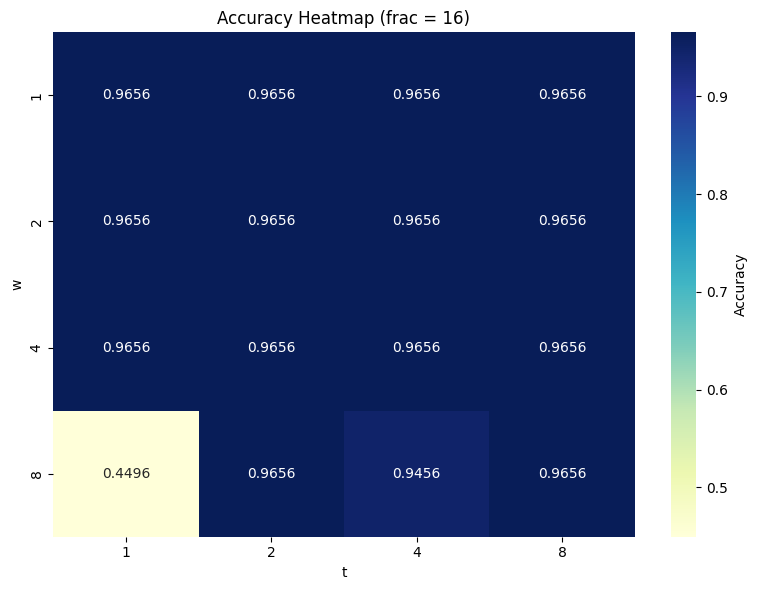

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = [
    # frac = 4
    {"frac": 4, "w": 1, "t": 1, "acc": 0.9656},
    {"frac": 4, "w": 1, "t": 2, "acc": 0.9632},
    {"frac": 4, "w": 1, "t": 4, "acc": 0.9656},
    {"frac": 4, "w": 1, "t": 8, "acc": 0.9656},
    {"frac": 4, "w": 2, "t": 1, "acc": 0.1512},
    {"frac": 4, "w": 2, "t": 2, "acc": 0.9656},
    {"frac": 4, "w": 2, "t": 4, "acc": 0.9576},
    {"frac": 4, "w": 2, "t": 8, "acc": 0.9656},
    {"frac": 4, "w": 4, "t": 1, "acc": 0.2504},
    {"frac": 4, "w": 4, "t": 2, "acc": 0.9656},
    {"frac": 4, "w": 4, "t": 4, "acc": 0.3512},
    {"frac": 4, "w": 4, "t": 8, "acc": 0.4760},
    {"frac": 4, "w": 8, "t": 1, "acc": 0.1520},
    {"frac": 4, "w": 8, "t": 2, "acc": 0.2136},
    {"frac": 4, "w": 8, "t": 4, "acc": 0.2840},
    {"frac": 4, "w": 8, "t": 8, "acc": 0.1832},

    # frac = 8
    {"frac": 8, "w": 1, "t": 1, "acc": 0.9392},
    {"frac": 8, "w": 1, "t": 2, "acc": 0.9624},
    {"frac": 8, "w": 1, "t": 4, "acc": 0.9656},
    {"frac": 8, "w": 1, "t": 8, "acc": 0.9656},
    {"frac": 8, "w": 2, "t": 1, "acc": 0.7584},
    {"frac": 8, "w": 2, "t": 2, "acc": 0.9656},
    {"frac": 8, "w": 2, "t": 4, "acc": 0.9656},
    {"frac": 8, "w": 2, "t": 8, "acc": 0.9656},
    {"frac": 8, "w": 4, "t": 1, "acc": 0.9656},
    {"frac": 8, "w": 4, "t": 2, "acc": 0.8008},
    {"frac": 8, "w": 4, "t": 4, "acc": 0.9656},
    {"frac": 8, "w": 4, "t": 8, "acc": 0.9048},
    {"frac": 8, "w": 8, "t": 1, "acc": 0.4168},
    {"frac": 8, "w": 8, "t": 2, "acc": 0.4576},
    {"frac": 8, "w": 8, "t": 4, "acc": 0.9072},
    {"frac": 8, "w": 8, "t": 8, "acc": 0.5728},

    # frac = 16
    {"frac": 16, "w": 1, "t": 1, "acc": 0.9656},
    {"frac": 16, "w": 1, "t": 2, "acc": 0.9656},
    {"frac": 16, "w": 1, "t": 4, "acc": 0.9656},
    {"frac": 16, "w": 1, "t": 8, "acc": 0.9656},
    {"frac": 16, "w": 2, "t": 1, "acc": 0.9656},
    {"frac": 16, "w": 2, "t": 2, "acc": 0.9656},
    {"frac": 16, "w": 2, "t": 4, "acc": 0.9656},
    {"frac": 16, "w": 2, "t": 8, "acc": 0.9656},
    {"frac": 16, "w": 4, "t": 1, "acc": 0.9656},
    {"frac": 16, "w": 4, "t": 2, "acc": 0.9656},
    {"frac": 16, "w": 4, "t": 4, "acc": 0.9656},
    {"frac": 16, "w": 4, "t": 8, "acc": 0.9656},
    {"frac": 16, "w": 8, "t": 1, "acc": 0.4496},
    {"frac": 16, "w": 8, "t": 2, "acc": 0.9656},
    {"frac": 16, "w": 8, "t": 4, "acc": 0.9456},
    {"frac": 16, "w": 8, "t": 8, "acc": 0.9656}
]

df = pd.DataFrame(data)

# Pivot for heatmap
frac_value = 16
pivot = df[df["frac"] == frac_value].pivot(index="w", columns="t", values="acc")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'Accuracy'})
plt.title(f'Accuracy Heatmap (frac = {frac_value})')
plt.xlabel("t")
plt.ylabel("w")
plt.tight_layout()
plt.show()


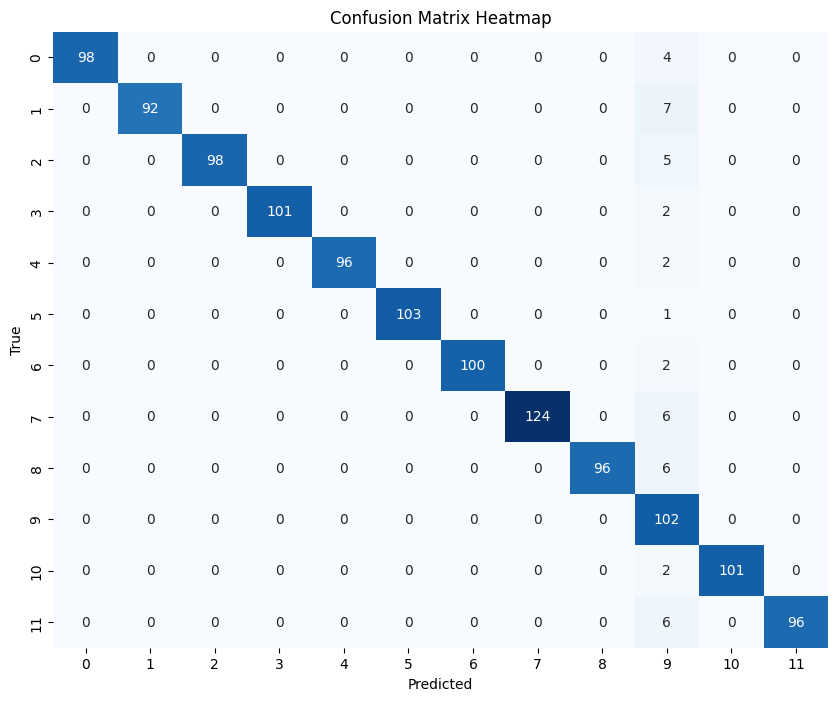

In [ ]:
# confusion matrix for the best model
import matplotlib.pyplot as plt
import seaborn as sns

cm = confs[32]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


# GNN



In [ ]:
!unzip MicrosoftGestureDataset.zip -d MSRC_12_GNN

Archive:  MicrosoftGestureDataset.zip
   creating: MSRC_12_GNN/MicrosoftGestureDataset-RC/code/
  inflating: MSRC_12_GNN/MicrosoftGestureDataset-RC/code/demo1.m  
  inflating: MSRC_12_GNN/MicrosoftGestureDataset-RC/code/load_file.m  
  inflating: MSRC_12_GNN/MicrosoftGestureDataset-RC/code/load_tagstream.m  
  inflating: MSRC_12_GNN/MicrosoftGestureDataset-RC/code/skel_model.m  
  inflating: MSRC_12_GNN/MicrosoftGestureDataset-RC/code/skel_vis.m  
  inflating: MSRC_12_GNN/MicrosoftGestureDataset-RC/code/tagstream_to_y.m  
  inflating: MSRC_12_GNN/MicrosoftGestureDataset-RC/code/verify_dataset.m  
   creating: MSRC_12_GNN/MicrosoftGestureDataset-RC/data/
  inflating: MSRC_12_GNN/MicrosoftGestureDataset-RC/data/P1_1_1_p06.csv  
  inflating: MSRC_12_GNN/MicrosoftGestureDataset-RC/data/P1_1_1_p06.tagstream  
  inflating: MSRC_12_GNN/MicrosoftGestureDataset-RC/data/P1_1_1_p19.csv  
  inflating: MSRC_12_GNN/MicrosoftGestureDataset-RC/data/P1_1_1_p19.tagstream  
  inflating: MSRC_12_GNN/Micro

In [ ]:
import os
import pandas as pd
import torch
import re

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
base_dir = "/content/MSRC_12_GNN"
csv_dir = os.path.join(base_dir, "csv")
tag_dir = os.path.join(base_dir, "tagstreams")